In [1]:
import numpy as np
import torch as th
import os
from matplotlib import pyplot as plt
from time import time as get_time
from AIGLE import AIGLE
from AIGLE.interpolation import interpolated_fes_2d
from AIGLE import Trajectory
from AIGLE.trainer import Trainer
from AIGLE.utilities import *

np.set_printoptions(precision=8)
dev = 'cuda' if th.cuda.is_available() else 'cpu'

## CG System Parameters
nmain = 20
k_main = 1000.0    # kJ/mol /nm^2
d_main = 0.3 

dt = 0.002 #ps
temp = 300
kb = 8.314462618e-3
kbT = kb * temp ## kJ/mol
 

## Create force engines

In [2]:
class harmonic_chain:
    def __init__(self, natoms, l0, k):
        self.natoms = natoms
        self.l0 = l0
        self.k = k
    def calc_force(self,r):
        assert r.ndim == 3
        assert r.shape[2] == 3
        f = th.zeros_like(r)
        l = (r[:,1:] - r[:,:-1])
        tension = self.k * l * (1 - self.l0 / l.norm(dim=-1)).unsqueeze(-1)
        f[:,:-1] += tension
        f[:,1:] -= tension
        return f

harmonic_int = harmonic_chain(natoms=nmain, l0=d_main, k=k_main)

## Load trajectories of coarse-grained variables (backbone atoms)

In [3]:
data = np.load('traj_2fs.npy')
traj = Trajectory(data, dt=dt, kbT=kbT)
traj.set_calculator(harmonic_int)
traj.process_kinetics(transform=False)

## Training GLE

In [5]:
taus = np.array([0.1, 0.6, 3])
aigle = AIGLE(ndim=nmain, kbT=kbT, ntau=taus.size, nfreq=4, taus=taus ).to(device=dev)
trainer = Trainer(aigle)
trainer.set_traj(traj)
if os.path.exists('gle_paras') is False:
    os.mkdir('gle_paras')
trainer.train(fit_time=6, niter=9005, lr_coef=0.4, lr_tau=0.01, print_freq=100, gamma=0.98, save_dir='gle_paras')

iter=0, loss=0.324893, tau=[0.10004645 0.6013837  3.0149398 ]
iter=100, loss=0.018020, tau=[0.16700664 0.76690704 1.5261376 ]
iter=200, loss=0.005946, tau=[0.2658349  0.86301315 1.4464772 ]
iter=300, loss=0.003705, tau=[0.2859988 0.8862254 1.4175403]
iter=400, loss=0.002895, tau=[0.2959226 0.8982865 1.3979877]
iter=500, loss=0.002449, tau=[0.3029559 0.9050473 1.3851551]
iter=600, loss=0.002153, tau=[0.3085913 0.9093744 1.3758106]
iter=700, loss=0.001937, tau=[0.31335217 0.91232306 1.368481  ]
iter=800, loss=0.001769, tau=[0.31747583 0.9143897  1.3623886 ]
iter=900, loss=0.001632, tau=[0.32109156 0.9158834  1.3571033 ]
iter=1000, loss=0.001518, tau=[0.32428512 0.9169998  1.3523961 ]
iter=1100, loss=0.001419, tau=[0.3271213 0.9178642 1.3481449]
iter=1200, loss=0.001334, tau=[0.32965493 0.91856104 1.3442786 ]
iter=1300, loss=0.001258, tau=[0.33184633 0.91922516 1.3407534 ]
iter=1400, loss=0.001191, tau=[0.33400467 0.9196592  1.3375324 ]
iter=1500, loss=0.001131, tau=[0.33593383 0.9200996 

## Validate GLE

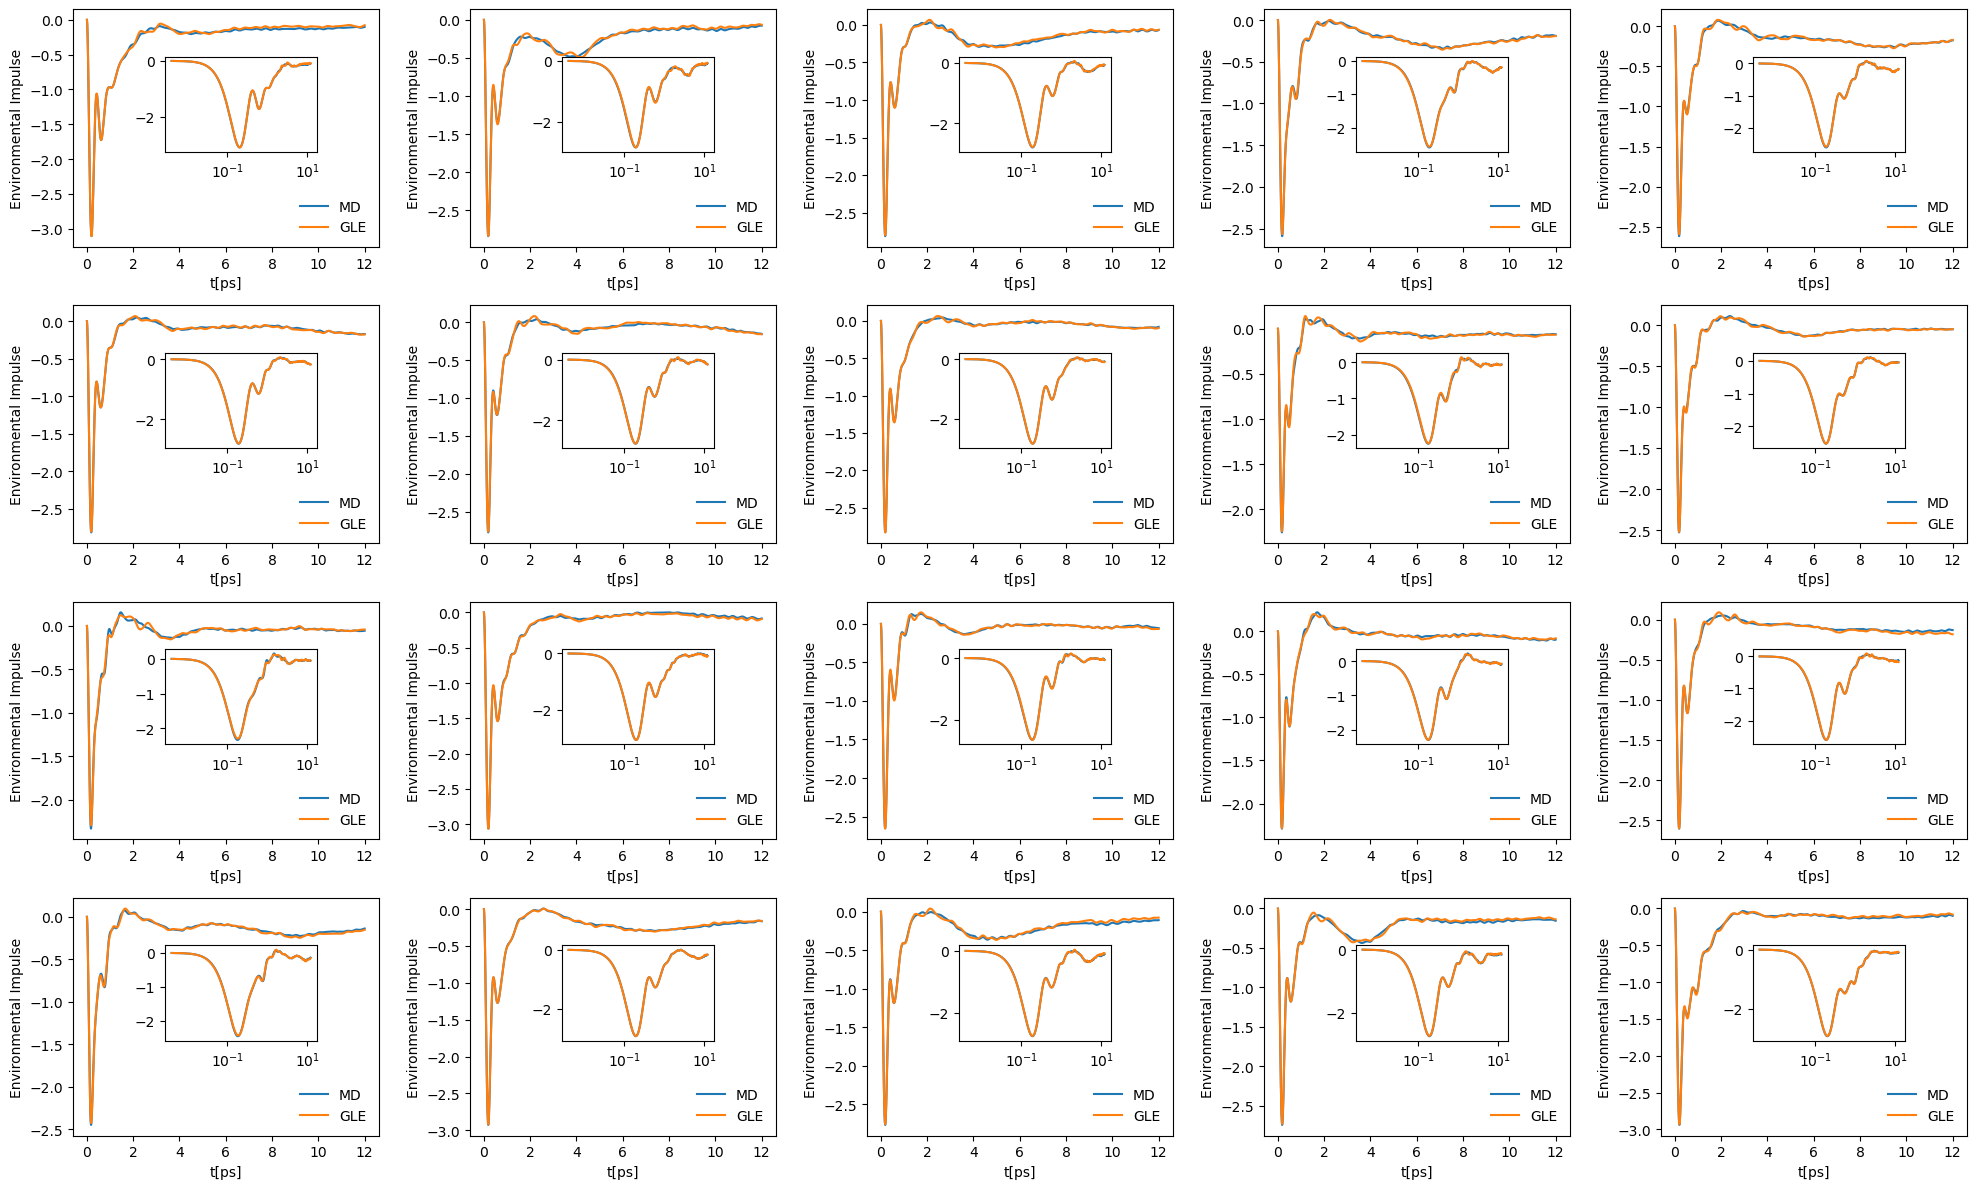

In [15]:
aigle = AIGLE(ndim=nmain, kbT=kbT, ntau=3, nfreq=4 ).to(device=dev)
aigle.load('gle_paras/model_iter_9000.json')
trainer = Trainer(aigle)
trainer.set_traj(traj)


val_time= 12
nmax = int(val_time/dt)
## Compare the impulse from non-conservative forces
impulse_mem, pred_impulse_mem = trainer.validate(val_time=val_time)
impulse_mem = th2np(impulse_mem)
pred_impulse_mem = th2np(pred_impulse_mem)
##
tgrid = np.arange(1, nmax+1) * dt
fig, ax_array = plt.subplots(nmain//5, 5, figsize=(20,12))
ax = ax_array.flatten()
for idx in range(nmain):
    ax[idx].plot(tgrid[1:], impulse_mem[1:,idx], label='MD')
    ax[idx].plot(tgrid[1:], pred_impulse_mem[:,idx], label='GLE')
    axins = ax[idx].inset_axes([0.3, 0.4, 0.5, 0.4])
    axins.semilogx(tgrid[1:] , impulse_mem[1:,idx]  )
    axins.semilogx(tgrid[1:] , pred_impulse_mem[:,idx] )
    ax[idx].legend(frameon=False)
    ax[idx].set_xlabel('t[ps]')
    ax[idx].set_ylabel('Environmental Impulse')
    
ax[-1].set_xlabel('t[ps]')
plt.tight_layout()

# plot memory kernel for the first two beads

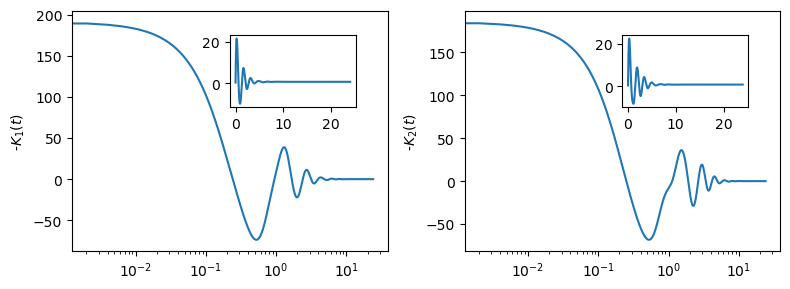

In [16]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
tgrid = np2th(np.arange(2*nmax)) * dt
mem_kernel = trainer.model.compute_memory_kernel(tgrid)  ## (ndim, nmax)
ax[0].semilogx(th2np(tgrid), -th2np(mem_kernel)[0])
ax[0].set_ylabel(r't[ps]')
ax[0].set_ylabel(r'-$K_1(t)$')
axins = ax[0].inset_axes([0.5, 0.6, 0.4, 0.3])
axins.plot(th2np(tgrid), -dt*np.cumsum((th2np(mem_kernel)[0]))) 

ax[1].semilogx(th2np(tgrid), -th2np(mem_kernel)[1])
ax[1].set_ylabel(r't[ps]')
ax[1].set_ylabel(r'-$K_2(t)$')
axins = ax[1].inset_axes([0.5, 0.6, 0.4, 0.3])
axins.plot(th2np(tgrid), -dt*np.cumsum((th2np(mem_kernel)[1]))) 
plt.tight_layout()